## <b>DeepFER: A Deep Neural Network model for Facial Expression Recognition</b>

### Import Libraries and Modules

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

### Implement the 'DeepFER' model using PyTorch

In [2]:
class DeepFER(nn.Module):
    def __init__(self):
        super(DeepFER, self).__init__()

        # Initialize weights with random Gaussian variables
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                init.normal_(layer.weight, mean=0.0, std=0.05)
                if layer.bias is not None:
                    init.constant_(layer.bias, 0.0)
                    
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        #self.dropout = nn.Dropout(0.3)  # Dropout layer
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=2)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=2)  # Corrected output channels
        self.bn8 = nn.BatchNorm2d(128)  # Matched with the output channels  
        
        # Update the input size of fc1 to match the output size of conv8
        self.fc1 = nn.Linear(18432, 256)  # Updated input size
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.35)  # Dropout layer
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 7)  # Output layer
            
    # Localization network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        # Regressor for the affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 53 * 53, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 53 * 53)  # Flatten the tensor
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.bn1(x)
        x = torch.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool1(x)
        x = torch.relu(self.conv3(x))
        x = self.bn3(x)
        x = torch.relu(self.conv4(x))
        #x = self.dropout(x)  # Apply dropout
        x = self.bn4(x)
        x = self.pool2(x)
        x = torch.relu(self.conv5(x))
        x = self.bn5(x)
        x = torch.relu(self.conv6(x))
        x = self.bn6(x)
        x = self.pool3(x)
        x = torch.relu(self.conv8(x))
        x = self.bn8(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # No softmax here as it will be applied in the loss function
        
        return x

##### Create instances of the DeepFER model

In [3]:
# Create an instance of the model
model_jaffe = DeepFER()

# Print the model architecture
print(model_jaffe)

DeepFER(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))

### JAFFE Dataset Training and Testing

In [4]:
from torchsummary import summary

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_jaffe.to(device)

# Specify input size (assuming grayscale images of size 48x48)
input_size = (1, 256, 256)  # (channels, height, width)

# Print the model summary
summary(model_jaffe, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 250, 250]           1,600
       BatchNorm2d-2         [-1, 32, 250, 250]              64
            Conv2d-3         [-1, 64, 246, 246]          51,264
       BatchNorm2d-4         [-1, 64, 246, 246]             128
         MaxPool2d-5         [-1, 64, 123, 123]               0
            Conv2d-6        [-1, 128, 119, 119]         204,928
       BatchNorm2d-7        [-1, 128, 119, 119]             256
            Conv2d-8        [-1, 128, 117, 117]         147,584
       BatchNorm2d-9        [-1, 128, 117, 117]             256
        MaxPool2d-10          [-1, 128, 58, 58]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 27, 27]         590,080
      BatchNorm2d-14          [-1, 256,

In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Set your data directory
data_dir = "M:\\Datasets\\Facial Expression Datasets\\JAFFE_Cropped"

# List of class names
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor()  # Convert to tensor
])

# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)

# Calculate sizes for train, validation, and test sets
total_samples = len(dataset)
train_size = int(0.701 * total_samples)
val_size = int(0.105 * total_samples)
test_size = total_samples - train_size - val_size

# Split the dataset into train, validation, and test sets
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Define batch size for dataloaders
batch_size = 16

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_pr = int(len(train_data)/total_samples*100)
val_pr = int(len(val_data)/total_samples*100)
test_pr = int(round(len(test_data)/total_samples*100+0.05))

# Print some information about the dataset
print(f"Total samples\t\t : {total_samples}")
print(f"Train samples\t\t : {len(train_data)}  ({train_pr}%)")
print(f"Validation samples\t : {len(val_data)}  ({val_pr}%)")
print(f"Test samples\t\t : {len(test_data)}  ({test_pr}%)")
print(f"Number of classes\t : {len(class_names)}")

Total samples		 : 1335
Train samples		 : 935  (70%)
Validation samples	 : 140  (10%)
Test samples		 : 260  (20%)
Number of classes	 : 7


In [6]:
# Create an instance of the model and move it to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_jaffe = DeepFER().to(device)

In [7]:
import torch.optim as optim
import time
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

# Hyperparameters
learning_rate = 1e-5
weight_decay = 1e-8  # L2 regularization
learning_rate_decay = 0.98  # Learning rate decay per epoch

# Adam parameters
beta1 = 0.99
beta2 = 0.999
epsilon = 1e-9

# Define the optimizer
optimizer = optim.Adam(
    model_jaffe.parameters(),
    lr=learning_rate,
    betas=(beta1, beta2),
    eps=epsilon,
    weight_decay=weight_decay
)

# Initialize variables for early stopping
best_val_loss = float('inf')
current_patience = 0
max_patience = 5  # Patience for early stopping

# Learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_decay)

In [8]:
# Define Early-stopping
# class EarlyStopping:
#     def __init__(self, patience=5, restore_best_weights=True):
#         self.patience = patience
#         self.restore_best_weights = restore_best_weights
#         self.counter = 0
#         self.best_val_loss = float('inf')
    
#     def __call__(self, val_loss, model):
#         if val_loss < self.best_val_loss:
#             self.best_val_loss = val_loss
#             self.counter = 0
#             if self.restore_best_weights:
#                 self.best_weights = model.state_dict()
#         else:
#             self.counter += 1
#         return self.counter >= self.patience

# early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model

num_epochs = 200

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

metrics_list = []  # List to store metrics for each epoch

for epoch in range(num_epochs):
    start_time = time.time()
    model_jaffe.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_X, batch_y in train_loader_iter:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model_jaffe(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_predictions += batch_y.size(0)
        correct_predictions += (predicted == batch_y).sum().item()

        total_loss += loss.item() * batch_X.size(0)

        train_loader_iter.set_postfix({"Train Loss": total_loss / total_predictions})

    train_accuracy = correct_predictions / total_predictions
    train_loss = total_loss / len(train_loader.dataset)

    # Validation loop
    model_jaffe.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs_val = model_jaffe(batch_X_val)
            loss_val = criterion(outputs_val, batch_y_val)

            _, predicted_val = torch.max(outputs_val, 1)
            val_total_predictions += batch_y_val.size(0)
            val_correct_predictions += (predicted_val == batch_y_val).sum().item()

            val_loss += loss_val.item() * batch_X_val.size(0)

    val_accuracy = val_correct_predictions / val_total_predictions
    val_loss = val_loss / len(val_loader.dataset)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Create dictionary for the epoch's metrics
    epoch_metrics = {
        'Epoch': epoch + 1,
        'Train Loss': train_loss,
        'Train Acc': train_accuracy,
        'Val Loss': val_loss,
        'Val Acc': val_accuracy
    }
    metrics_list.append(epoch_metrics)
    
    # Early Stopping Check
#     if early_stopping(val_loss, model):
#         print(f"Early stopping at epoch {epoch}!")
#         break
    
    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
          f"Time: {epoch_time:.2f} seconds")

# Create a DataFrame from the metrics_list
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame as a CSV file
metrics_df.to_csv('my_deep_training_metrics.csv', index=False)

Epoch [1/200] - Train Loss: 1.9300, Train Acc: 0.1743, Val Loss: 1.9228, Val Acc: 0.1571, Time: 9.17 seconds


Epoch [2/200] - Train Loss: 1.8683, Train Acc: 0.3230, Val Loss: 1.8421, Val Acc: 0.3786, Time: 8.75 seconds


Epoch [3/200] - Train Loss: 1.7750, Train Acc: 0.4717, Val Loss: 1.7524, Val Acc: 0.5357, Time: 8.91 seconds


Epoch [4/200] - Train Loss: 1.6775, Train Acc: 0.5144, Val Loss: 1.6579, Val Acc: 0.5500, Time: 8.59 seconds


Epoch [5/200] - Train Loss: 1.5605, Train Acc: 0.5882, Val Loss: 1.5392, Val Acc: 0.6071, Time: 8.43 seconds


Epoch [6/200] - Train Loss: 1.4275, Train Acc: 0.6610, Val Loss: 1.4240, Val Acc: 0.6643, Time: 8.43 seconds


Epoch [7/200] - Train Loss: 1.3026, Train Acc: 0.7251, Val Loss: 1.3099, Val Acc: 0.7000, Time: 8.42 seconds


Epoch [8/200] - Train Loss: 1.1838, Train Acc: 0.7743, Val Loss: 1.2007, Val Acc: 0.7214, Time: 8.64 seconds


Epoch [9/200] - Train Loss: 1.0544, Train Acc: 0.8011, Val Loss: 1.0940, Val Acc: 0.7571, Time: 8.45 seconds


Epoch [10/200] - Train Loss: 0.9201, Train Acc: 0.8417, Val Loss: 0.9889, Val Acc: 0.7714, Time: 8.82 seconds


Epoch [11/200] - Train Loss: 0.8100, Train Acc: 0.8930, Val Loss: 0.8977, Val Acc: 0.8214, Time: 8.63 seconds


Epoch [12/200] - Train Loss: 0.7119, Train Acc: 0.9048, Val Loss: 0.8206, Val Acc: 0.8500, Time: 8.53 seconds


Epoch [13/200] - Train Loss: 0.6353, Train Acc: 0.9166, Val Loss: 0.7293, Val Acc: 0.8571, Time: 8.45 seconds


Epoch [14/200] - Train Loss: 0.5172, Train Acc: 0.9422, Val Loss: 0.6769, Val Acc: 0.8714, Time: 8.50 seconds


Epoch [15/200] - Train Loss: 0.4629, Train Acc: 0.9444, Val Loss: 0.6201, Val Acc: 0.8643, Time: 8.78 seconds


Epoch [16/200] - Train Loss: 0.3987, Train Acc: 0.9658, Val Loss: 0.5647, Val Acc: 0.8714, Time: 8.96 seconds


Epoch [17/200] - Train Loss: 0.3315, Train Acc: 0.9850, Val Loss: 0.5194, Val Acc: 0.8929, Time: 8.96 seconds


Epoch [18/200] - Train Loss: 0.2889, Train Acc: 0.9829, Val Loss: 0.4944, Val Acc: 0.8786, Time: 8.79 seconds


Epoch [19/200] - Train Loss: 0.2225, Train Acc: 0.9925, Val Loss: 0.4565, Val Acc: 0.8786, Time: 8.61 seconds


Epoch [20/200] - Train Loss: 0.2070, Train Acc: 0.9936, Val Loss: 0.4322, Val Acc: 0.9071, Time: 8.71 seconds


Epoch [21/200] - Train Loss: 0.1824, Train Acc: 0.9936, Val Loss: 0.4092, Val Acc: 0.8857, Time: 8.60 seconds


Epoch [22/200] - Train Loss: 0.1531, Train Acc: 0.9957, Val Loss: 0.3966, Val Acc: 0.8929, Time: 8.69 seconds


Epoch [23/200] - Train Loss: 0.1401, Train Acc: 0.9968, Val Loss: 0.3796, Val Acc: 0.9000, Time: 8.50 seconds


Epoch [24/200] - Train Loss: 0.1146, Train Acc: 0.9979, Val Loss: 0.3656, Val Acc: 0.9000, Time: 8.48 seconds


Epoch [25/200] - Train Loss: 0.0983, Train Acc: 0.9968, Val Loss: 0.3603, Val Acc: 0.9000, Time: 8.53 seconds


Epoch [26/200] - Train Loss: 0.0972, Train Acc: 0.9979, Val Loss: 0.3560, Val Acc: 0.9071, Time: 8.48 seconds


Epoch [27/200] - Train Loss: 0.0808, Train Acc: 0.9989, Val Loss: 0.3515, Val Acc: 0.9000, Time: 8.66 seconds


Epoch [28/200] - Train Loss: 0.0717, Train Acc: 0.9989, Val Loss: 0.3490, Val Acc: 0.9071, Time: 8.60 seconds


Epoch [29/200] - Train Loss: 0.0634, Train Acc: 1.0000, Val Loss: 0.3401, Val Acc: 0.9071, Time: 9.03 seconds


Epoch [30/200] - Train Loss: 0.0569, Train Acc: 1.0000, Val Loss: 0.3228, Val Acc: 0.9000, Time: 9.06 seconds


Epoch [31/200] - Train Loss: 0.0506, Train Acc: 1.0000, Val Loss: 0.3230, Val Acc: 0.9143, Time: 9.35 seconds


Epoch [32/200] - Train Loss: 0.0446, Train Acc: 1.0000, Val Loss: 0.3184, Val Acc: 0.9000, Time: 9.06 seconds


Epoch [33/200] - Train Loss: 0.0426, Train Acc: 0.9979, Val Loss: 0.3203, Val Acc: 0.9071, Time: 8.83 seconds


Epoch [34/200] - Train Loss: 0.0381, Train Acc: 0.9989, Val Loss: 0.3131, Val Acc: 0.9143, Time: 9.01 seconds


Epoch [35/200] - Train Loss: 0.0344, Train Acc: 1.0000, Val Loss: 0.3151, Val Acc: 0.9143, Time: 8.55 seconds


Epoch [36/200] - Train Loss: 0.0342, Train Acc: 0.9989, Val Loss: 0.3133, Val Acc: 0.9000, Time: 8.57 seconds


Epoch [37/200] - Train Loss: 0.0277, Train Acc: 1.0000, Val Loss: 0.3076, Val Acc: 0.9071, Time: 8.36 seconds


Epoch [38/200] - Train Loss: 0.0257, Train Acc: 1.0000, Val Loss: 0.3090, Val Acc: 0.9071, Time: 8.42 seconds


Epoch [39/200] - Train Loss: 0.0265, Train Acc: 1.0000, Val Loss: 0.3053, Val Acc: 0.9071, Time: 8.52 seconds


Epoch [40/200] - Train Loss: 0.0234, Train Acc: 1.0000, Val Loss: 0.3031, Val Acc: 0.9071, Time: 8.44 seconds


Epoch [41/200] - Train Loss: 0.0215, Train Acc: 1.0000, Val Loss: 0.2940, Val Acc: 0.9143, Time: 9.22 seconds


Epoch [42/200] - Train Loss: 0.0199, Train Acc: 1.0000, Val Loss: 0.3006, Val Acc: 0.9143, Time: 9.01 seconds


Epoch [43/200] - Train Loss: 0.0195, Train Acc: 1.0000, Val Loss: 0.3053, Val Acc: 0.9143, Time: 9.96 seconds


Epoch [44/200] - Train Loss: 0.0170, Train Acc: 1.0000, Val Loss: 0.2924, Val Acc: 0.9143, Time: 8.97 seconds


Epoch [45/200] - Train Loss: 0.0159, Train Acc: 1.0000, Val Loss: 0.2965, Val Acc: 0.9143, Time: 8.71 seconds


Epoch [46/200] - Train Loss: 0.0184, Train Acc: 0.9989, Val Loss: 0.3044, Val Acc: 0.9071, Time: 8.86 seconds


Epoch [47/200] - Train Loss: 0.0126, Train Acc: 1.0000, Val Loss: 0.2935, Val Acc: 0.9143, Time: 8.80 seconds


Epoch [48/200] - Train Loss: 0.0126, Train Acc: 1.0000, Val Loss: 0.2883, Val Acc: 0.9143, Time: 8.81 seconds


Epoch [49/200] - Train Loss: 0.0123, Train Acc: 1.0000, Val Loss: 0.2906, Val Acc: 0.9143, Time: 8.74 seconds


Epoch [50/200] - Train Loss: 0.0110, Train Acc: 1.0000, Val Loss: 0.2959, Val Acc: 0.9143, Time: 8.81 seconds


Epoch [51/200] - Train Loss: 0.0103, Train Acc: 1.0000, Val Loss: 0.2962, Val Acc: 0.9143, Time: 8.51 seconds


Epoch [52/200] - Train Loss: 0.0104, Train Acc: 1.0000, Val Loss: 0.2957, Val Acc: 0.9071, Time: 8.80 seconds


Epoch [53/200] - Train Loss: 0.0094, Train Acc: 1.0000, Val Loss: 0.2959, Val Acc: 0.9071, Time: 8.57 seconds


Epoch [54/200] - Train Loss: 0.0097, Train Acc: 1.0000, Val Loss: 0.2948, Val Acc: 0.9143, Time: 8.45 seconds


Epoch [55/200] - Train Loss: 0.0076, Train Acc: 1.0000, Val Loss: 0.2866, Val Acc: 0.9143, Time: 8.59 seconds


Epoch [56/200] - Train Loss: 0.0081, Train Acc: 1.0000, Val Loss: 0.2815, Val Acc: 0.9143, Time: 8.71 seconds


Epoch [57/200] - Train Loss: 0.0090, Train Acc: 1.0000, Val Loss: 0.2833, Val Acc: 0.9214, Time: 8.38 seconds


Epoch [58/200] - Train Loss: 0.0068, Train Acc: 1.0000, Val Loss: 0.2851, Val Acc: 0.9143, Time: 8.57 seconds


Epoch [59/200] - Train Loss: 0.0077, Train Acc: 1.0000, Val Loss: 0.2891, Val Acc: 0.9143, Time: 8.66 seconds


Epoch [60/200] - Train Loss: 0.0074, Train Acc: 1.0000, Val Loss: 0.2823, Val Acc: 0.9143, Time: 8.93 seconds


Epoch [61/200] - Train Loss: 0.0068, Train Acc: 1.0000, Val Loss: 0.2780, Val Acc: 0.9071, Time: 8.98 seconds


Epoch [62/200] - Train Loss: 0.0057, Train Acc: 1.0000, Val Loss: 0.2826, Val Acc: 0.9071, Time: 8.48 seconds


Epoch [63/200] - Train Loss: 0.0053, Train Acc: 1.0000, Val Loss: 0.2795, Val Acc: 0.9214, Time: 8.74 seconds


Epoch [64/200] - Train Loss: 0.0050, Train Acc: 1.0000, Val Loss: 0.2786, Val Acc: 0.9143, Time: 8.72 seconds


Epoch [65/200] - Train Loss: 0.0045, Train Acc: 1.0000, Val Loss: 0.2816, Val Acc: 0.9143, Time: 8.43 seconds


Epoch [66/200] - Train Loss: 0.0045, Train Acc: 1.0000, Val Loss: 0.2843, Val Acc: 0.9214, Time: 8.88 seconds


Epoch [67/200] - Train Loss: 0.0052, Train Acc: 1.0000, Val Loss: 0.2821, Val Acc: 0.9143, Time: 8.65 seconds


Epoch [68/200] - Train Loss: 0.0043, Train Acc: 1.0000, Val Loss: 0.2844, Val Acc: 0.9143, Time: 9.03 seconds


Epoch [69/200] - Train Loss: 0.0052, Train Acc: 1.0000, Val Loss: 0.2933, Val Acc: 0.9071, Time: 8.59 seconds


Epoch [70/200] - Train Loss: 0.0048, Train Acc: 1.0000, Val Loss: 0.2953, Val Acc: 0.9143, Time: 8.87 seconds


Epoch [71/200] - Train Loss: 0.0051, Train Acc: 0.9989, Val Loss: 0.3004, Val Acc: 0.9071, Time: 8.45 seconds


Epoch [72/200] - Train Loss: 0.0044, Train Acc: 1.0000, Val Loss: 0.2950, Val Acc: 0.9143, Time: 8.41 seconds


Epoch [73/200] - Train Loss: 0.0038, Train Acc: 1.0000, Val Loss: 0.2928, Val Acc: 0.9214, Time: 8.63 seconds


Epoch [74/200] - Train Loss: 0.0032, Train Acc: 1.0000, Val Loss: 0.2866, Val Acc: 0.9143, Time: 8.45 seconds


Epoch [75/200] - Train Loss: 0.0038, Train Acc: 1.0000, Val Loss: 0.2957, Val Acc: 0.9143, Time: 8.50 seconds


Epoch [76/200] - Train Loss: 0.0029, Train Acc: 1.0000, Val Loss: 0.3022, Val Acc: 0.9143, Time: 8.50 seconds


Epoch [77/200] - Train Loss: 0.0025, Train Acc: 1.0000, Val Loss: 0.2980, Val Acc: 0.9143, Time: 8.56 seconds


Epoch [78/200] - Train Loss: 0.0025, Train Acc: 1.0000, Val Loss: 0.2881, Val Acc: 0.9143, Time: 8.40 seconds


Epoch [79/200] - Train Loss: 0.0028, Train Acc: 1.0000, Val Loss: 0.2879, Val Acc: 0.9143, Time: 8.37 seconds


Epoch [80/200] - Train Loss: 0.0029, Train Acc: 1.0000, Val Loss: 0.2957, Val Acc: 0.9143, Time: 8.43 seconds


Epoch [81/200] - Train Loss: 0.0027, Train Acc: 1.0000, Val Loss: 0.2851, Val Acc: 0.9143, Time: 8.43 seconds


Epoch [82/200] - Train Loss: 0.0024, Train Acc: 1.0000, Val Loss: 0.2817, Val Acc: 0.9143, Time: 8.40 seconds


Epoch [83/200] - Train Loss: 0.0025, Train Acc: 1.0000, Val Loss: 0.2831, Val Acc: 0.9143, Time: 8.40 seconds


Epoch [84/200] - Train Loss: 0.0020, Train Acc: 1.0000, Val Loss: 0.2919, Val Acc: 0.9143, Time: 8.50 seconds


Epoch [85/200] - Train Loss: 0.0019, Train Acc: 1.0000, Val Loss: 0.2894, Val Acc: 0.9214, Time: 8.41 seconds


Epoch [86/200] - Train Loss: 0.0019, Train Acc: 1.0000, Val Loss: 0.2851, Val Acc: 0.9143, Time: 8.38 seconds


Epoch [87/200] - Train Loss: 0.0021, Train Acc: 1.0000, Val Loss: 0.2826, Val Acc: 0.9071, Time: 8.43 seconds


Epoch [88/200] - Train Loss: 0.0021, Train Acc: 1.0000, Val Loss: 0.2886, Val Acc: 0.9143, Time: 8.40 seconds


Epoch [89/200] - Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 0.2905, Val Acc: 0.9214, Time: 8.46 seconds


Epoch [90/200] - Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 0.2862, Val Acc: 0.9143, Time: 8.47 seconds


Epoch [91/200] - Train Loss: 0.0017, Train Acc: 1.0000, Val Loss: 0.2826, Val Acc: 0.9071, Time: 8.47 seconds


Epoch [92/200] - Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.2818, Val Acc: 0.9071, Time: 8.41 seconds


Epoch [93/200] - Train Loss: 0.0014, Train Acc: 1.0000, Val Loss: 0.2823, Val Acc: 0.9071, Time: 8.39 seconds


Epoch [94/200] - Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.2811, Val Acc: 0.9143, Time: 8.41 seconds


Epoch [95/200] - Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 0.2872, Val Acc: 0.9143, Time: 8.43 seconds


Epoch [96/200] - Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.2879, Val Acc: 0.9071, Time: 8.42 seconds


Epoch [97/200] - Train Loss: 0.0017, Train Acc: 1.0000, Val Loss: 0.2879, Val Acc: 0.9143, Time: 8.41 seconds


Epoch [98/200] - Train Loss: 0.0016, Train Acc: 1.0000, Val Loss: 0.2960, Val Acc: 0.9071, Time: 8.46 seconds


Epoch [99/200] - Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.2953, Val Acc: 0.9071, Time: 8.40 seconds


Epoch [100/200] - Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.2896, Val Acc: 0.9071, Time: 8.46 seconds


Epoch [101/200] - Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.2881, Val Acc: 0.9214, Time: 8.42 seconds


Epoch [102/200] - Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.2932, Val Acc: 0.9214, Time: 8.44 seconds


Epoch [103/200] - Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.2879, Val Acc: 0.9143, Time: 8.39 seconds


Epoch [104/200] - Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.2952, Val Acc: 0.9071, Time: 8.49 seconds


Epoch [105/200] - Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.2931, Val Acc: 0.9143, Time: 8.47 seconds


Epoch [106/200] - Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.2834, Val Acc: 0.9214, Time: 8.42 seconds


Epoch [107/200] - Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.2802, Val Acc: 0.9214, Time: 8.42 seconds


Epoch [108/200] - Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.2799, Val Acc: 0.9143, Time: 8.44 seconds


Epoch [109/200] - Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.2803, Val Acc: 0.9143, Time: 8.45 seconds


Epoch [110/200] - Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.2805, Val Acc: 0.9071, Time: 8.37 seconds


Epoch [111/200] - Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.2777, Val Acc: 0.9214, Time: 8.46 seconds


Epoch [112/200] - Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.2849, Val Acc: 0.9214, Time: 8.47 seconds


Epoch [113/200] - Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.2737, Val Acc: 0.9214, Time: 8.44 seconds


Epoch [114/200] - Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.2739, Val Acc: 0.9214, Time: 8.38 seconds


Epoch [115/200] - Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.2844, Val Acc: 0.9214, Time: 8.36 seconds


Epoch [116/200] - Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.2912, Val Acc: 0.9286, Time: 8.52 seconds


Epoch [117/200] - Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.2914, Val Acc: 0.9214, Time: 8.40 seconds


Epoch [118/200] - Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.2984, Val Acc: 0.9143, Time: 8.81 seconds


Epoch [119/200] - Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.3028, Val Acc: 0.9143, Time: 8.51 seconds


Epoch [120/200] - Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.3035, Val Acc: 0.9214, Time: 8.58 seconds


Epoch [121/200] - Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.2977, Val Acc: 0.9214, Time: 8.58 seconds


Epoch [122/200] - Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.3044, Val Acc: 0.9143, Time: 8.37 seconds


Epoch [123/200] - Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.3281, Val Acc: 0.9143, Time: 8.45 seconds


Epoch [124/200] - Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.3382, Val Acc: 0.9000, Time: 8.43 seconds


Epoch [125/200] - Train Loss: 0.0016, Train Acc: 1.0000, Val Loss: 0.3164, Val Acc: 0.8786, Time: 8.40 seconds


Epoch [126/200] - Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.3172, Val Acc: 0.9000, Time: 8.42 seconds


Epoch [127/200] - Train Loss: 0.0008, Train Acc: 1.0000, Val Loss: 0.3225, Val Acc: 0.9000, Time: 8.49 seconds


Epoch [128/200] - Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.2858, Val Acc: 0.9000, Time: 8.40 seconds


Epoch [129/200] - Train Loss: 0.0015, Train Acc: 1.0000, Val Loss: 0.2940, Val Acc: 0.9143, Time: 8.37 seconds


Epoch [130/200] - Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.3427, Val Acc: 0.9071, Time: 8.44 seconds


Epoch [131/200] - Train Loss: 0.0012, Train Acc: 1.0000, Val Loss: 0.3813, Val Acc: 0.8857, Time: 8.39 seconds


Epoch [132/200] - Train Loss: 0.0009, Train Acc: 1.0000, Val Loss: 0.3200, Val Acc: 0.9071, Time: 8.51 seconds


Epoch [133/200] - Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.2973, Val Acc: 0.9000, Time: 8.44 seconds


Epoch [134/200] - Train Loss: 0.0010, Train Acc: 1.0000, Val Loss: 0.3053, Val Acc: 0.9000, Time: 8.51 seconds


Epoch [135/200] - Train Loss: 0.0015, Train Acc: 0.9989, Val Loss: 0.3425, Val Acc: 0.9000, Time: 8.37 seconds


Epoch [136/200] - Train Loss: 0.0046, Train Acc: 0.9989, Val Loss: 0.3441, Val Acc: 0.9143, Time: 8.39 seconds


Epoch [137/200] - Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.3467, Val Acc: 0.8929, Time: 8.45 seconds


Epoch [138/200] - Train Loss: 0.0015, Train Acc: 1.0000, Val Loss: 0.3128, Val Acc: 0.9071, Time: 8.40 seconds


Epoch [139/200] - Train Loss: 0.0013, Train Acc: 1.0000, Val Loss: 0.3037, Val Acc: 0.9143, Time: 8.42 seconds


Epoch [140/200] - Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.3082, Val Acc: 0.9214, Time: 8.40 seconds


Epoch [141/200] - Train Loss: 0.0006, Train Acc: 1.0000, Val Loss: 0.3069, Val Acc: 0.9286, Time: 8.45 seconds


Epoch [142/200] - Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.3191, Val Acc: 0.9143, Time: 8.38 seconds


Epoch [143/200] - Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.3305, Val Acc: 0.9071, Time: 8.42 seconds


Epoch [144/200] - Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.3298, Val Acc: 0.9071, Time: 8.31 seconds


Epoch [145/200] - Train Loss: 0.0005, Train Acc: 1.0000, Val Loss: 0.3196, Val Acc: 0.9071, Time: 8.34 seconds


Epoch [146/200] - Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.3185, Val Acc: 0.9143, Time: 8.27 seconds


Epoch [147/200] - Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.3169, Val Acc: 0.9214, Time: 8.33 seconds


Epoch [148/200] - Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.3182, Val Acc: 0.9143, Time: 8.29 seconds


Epoch [149/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3146, Val Acc: 0.9143, Time: 8.28 seconds


Epoch [150/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3191, Val Acc: 0.9143, Time: 8.22 seconds


Epoch [151/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3204, Val Acc: 0.9214, Time: 8.24 seconds


Epoch [152/200] - Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 0.3219, Val Acc: 0.9214, Time: 8.35 seconds


Epoch [153/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3476, Val Acc: 0.8929, Time: 8.27 seconds


Epoch [154/200] - Train Loss: 0.0007, Train Acc: 1.0000, Val Loss: 0.3176, Val Acc: 0.9143, Time: 8.23 seconds


Epoch [155/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3181, Val Acc: 0.9071, Time: 8.32 seconds


Epoch [156/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3204, Val Acc: 0.9071, Time: 8.31 seconds


Epoch [157/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3162, Val Acc: 0.9071, Time: 8.22 seconds


Epoch [158/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3085, Val Acc: 0.9071, Time: 8.21 seconds


Epoch [159/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3097, Val Acc: 0.9071, Time: 8.30 seconds


Epoch [160/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3162, Val Acc: 0.9143, Time: 8.26 seconds


Epoch [161/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3266, Val Acc: 0.9143, Time: 8.38 seconds


Epoch [162/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3279, Val Acc: 0.9143, Time: 8.29 seconds


Epoch [163/200] - Train Loss: 0.0003, Train Acc: 1.0000, Val Loss: 0.3203, Val Acc: 0.9214, Time: 8.30 seconds


Epoch [164/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3074, Val Acc: 0.9143, Time: 8.24 seconds


Epoch [165/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3045, Val Acc: 0.9143, Time: 8.25 seconds


Epoch [166/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.2992, Val Acc: 0.9143, Time: 8.29 seconds


Epoch [167/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.2996, Val Acc: 0.9071, Time: 8.25 seconds


Epoch [168/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.2990, Val Acc: 0.9143, Time: 8.27 seconds


Epoch [169/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.2999, Val Acc: 0.9071, Time: 8.24 seconds


Epoch [170/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3041, Val Acc: 0.9214, Time: 8.31 seconds


Epoch [171/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3045, Val Acc: 0.9214, Time: 8.25 seconds


Epoch [172/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3127, Val Acc: 0.9286, Time: 8.24 seconds


Epoch [173/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3113, Val Acc: 0.9286, Time: 8.27 seconds


Epoch [174/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3170, Val Acc: 0.9214, Time: 8.27 seconds


Epoch [175/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3250, Val Acc: 0.9286, Time: 8.29 seconds


Epoch [176/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3325, Val Acc: 0.9214, Time: 8.35 seconds


Epoch [177/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3348, Val Acc: 0.9143, Time: 8.42 seconds


Epoch [178/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.3254, Val Acc: 0.9286, Time: 8.23 seconds


Epoch [179/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3138, Val Acc: 0.9286, Time: 8.25 seconds


Epoch [180/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3026, Val Acc: 0.9286, Time: 8.27 seconds


Epoch [181/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3061, Val Acc: 0.9214, Time: 8.30 seconds


Epoch [182/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3046, Val Acc: 0.9286, Time: 8.21 seconds


Epoch [183/200] - Train Loss: 0.0002, Train Acc: 1.0000, Val Loss: 0.2981, Val Acc: 0.9214, Time: 8.27 seconds


Epoch [184/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.2988, Val Acc: 0.9214, Time: 8.29 seconds


Epoch [185/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3102, Val Acc: 0.9143, Time: 8.25 seconds


Epoch [186/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3117, Val Acc: 0.9143, Time: 8.21 seconds


Epoch [187/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3130, Val Acc: 0.9143, Time: 8.26 seconds


Epoch [188/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3183, Val Acc: 0.9214, Time: 8.38 seconds


Epoch [189/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3215, Val Acc: 0.9214, Time: 8.25 seconds


Epoch [190/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3211, Val Acc: 0.9214, Time: 8.50 seconds


Epoch [191/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3228, Val Acc: 0.9214, Time: 8.55 seconds


Epoch [192/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3245, Val Acc: 0.9214, Time: 8.44 seconds


Epoch [193/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3167, Val Acc: 0.9214, Time: 8.46 seconds


Epoch [194/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3190, Val Acc: 0.9214, Time: 8.40 seconds


Epoch [195/200] - Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.3205, Val Acc: 0.9214, Time: 8.36 seconds


Epoch [196/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3243, Val Acc: 0.9214, Time: 8.25 seconds


Epoch [197/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3159, Val Acc: 0.9214, Time: 8.26 seconds


Epoch [198/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3216, Val Acc: 0.9214, Time: 8.39 seconds


Epoch [199/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3309, Val Acc: 0.9214, Time: 8.44 seconds


Epoch [200/200] - Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.3335, Val Acc: 0.9143, Time: 8.29 seconds


In [9]:
# Save the trained model weights
torch.save(model_jaffe.state_dict(), 'path_to_my_model_jaffe.pth')

In [10]:
# Load the CSV file
metrics_df = pd.read_csv('my_deep_training_metrics.csv')

# Fetch the values into variables
epochs = metrics_df['Epoch'].values
train_losses = metrics_df['Train Loss'].values
train_accuracies = metrics_df['Train Acc'].values
val_losses = metrics_df['Val Loss'].values
val_accuracies = metrics_df['Val Acc'].values

In [11]:
val_acc_avg = sum(val_accuracies)/num_epochs

print(f"Average Validation Accuracy : {(val_acc_avg*100):.2f} %")

Average Validation Accuracy : 89.45 %


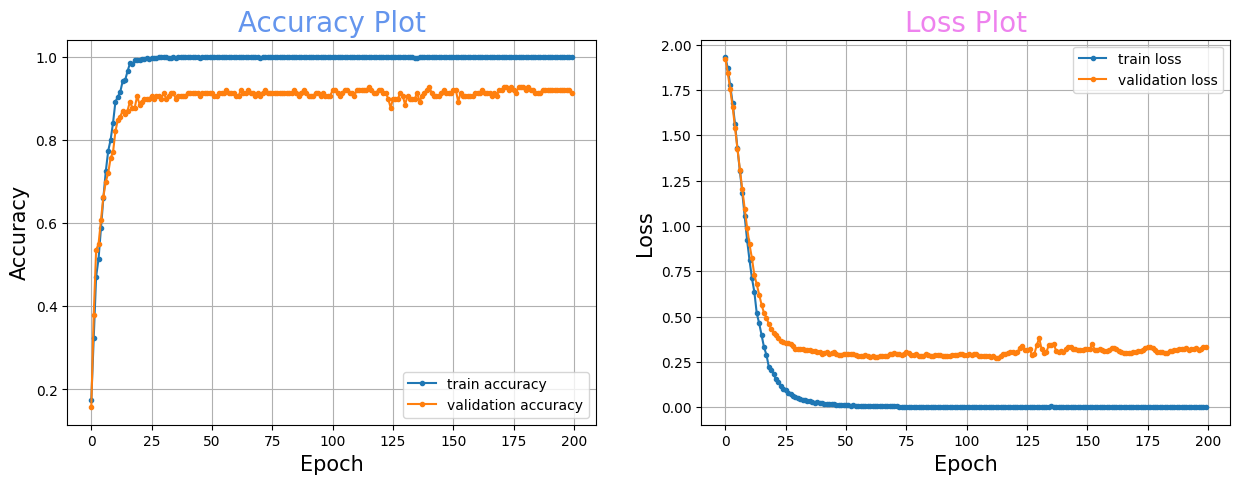

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Accuracy Plot", size=20, color='cornflowerblue')
plt.plot(train_accuracies, '.-', label='train accuracy')
plt.plot(val_accuracies, '.-', label='validation accuracy')
plt.xlabel('Epoch', size=15)
plt.ylabel('Accuracy', size=15)
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.title("Loss Plot", size=20, color='violet')
plt.plot(train_losses, '.-', label='train loss')
plt.plot(val_losses, '.-', label='validation loss')
plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [13]:
import time
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Accuracy: 0.8962


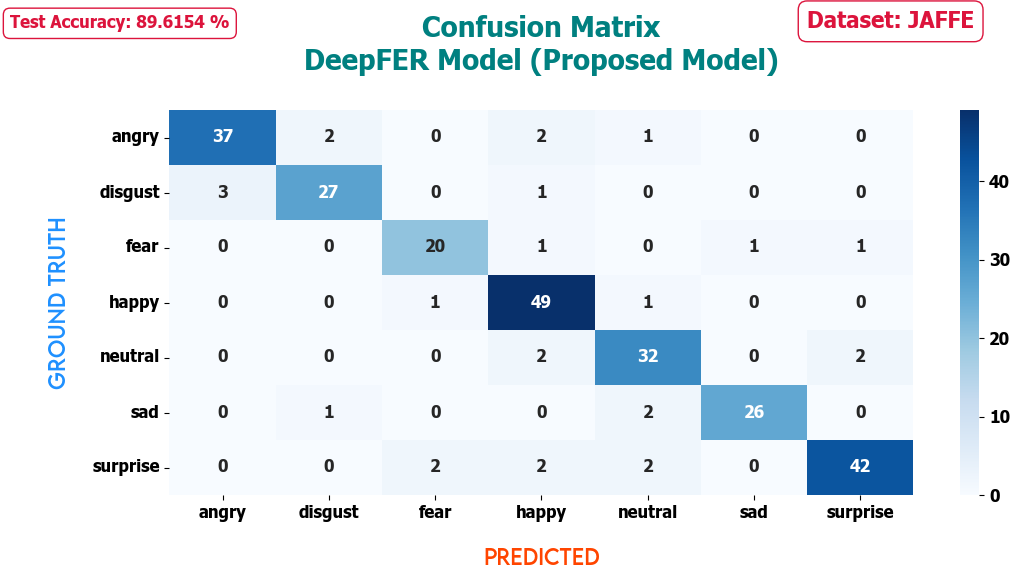

Classification Report:
              precision    recall  f1-score   support

       angry       0.93      0.88      0.90        42
     disgust       0.90      0.87      0.89        31
        fear       0.87      0.87      0.87        23
       happy       0.86      0.96      0.91        51
     neutral       0.84      0.89      0.86        36
         sad       0.96      0.90      0.93        29
    surprise       0.93      0.88      0.90        48

    accuracy                           0.90       260
   macro avg       0.90      0.89      0.89       260
weighted avg       0.90      0.90      0.90       260



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model_jaffe, test_loader, class_names):
    model_jaffe.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_jaffe(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

    confusion = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 5))
    # Plotting font customization
    plt.rcParams["font.family"] = "Tahoma"
    plt.rcParams["font.size"] = 12
    plt.rcParams["font.weight"] = "bold"
    # Heatmap
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # Plot Labels
    plt.xlabel('\nPredicted', size=15, color='orangered', fontname="LEMON MILK")
    plt.ylabel('Ground Truth\n', size=15, color='dodgerblue', fontname="LEMON MILK")
    plt.title('Confusion Matrix\nDeepFER Model (Proposed Model)\n', size=20, color='teal', 
              fontname="Tahoma", fontweight="bold")
    
    plt.text(-1.5, -1.5, f"Test Accuracy: {100*accuracy:.4f} %", fontsize=12, color='crimson',
         bbox=dict(facecolor='white', edgecolor='crimson', boxstyle='round,pad=0.4'))
    
    plt.text(6, -1.5, f"Dataset: JAFFE", fontsize=16, color='crimson',
         bbox=dict(facecolor='white', edgecolor='crimson', boxstyle='round,pad=0.4'))
    
    plt.show()

    class_report = classification_report(all_labels, all_preds, target_names=class_names)
    print('Classification Report:')
    print(class_report)

# Create an instance of the model
model_jaffe = DeepFER()

# Load the saved model weights
model_jaffe.load_state_dict(torch.load('path_to_my_model_jaffe.pth'))
model_jaffe.to(device)

# Define your test loader and class names
# Assuming test_loader and class_names are defined

# Call the evaluate_model function
evaluate_model(model_jaffe, test_loader, class_names)